## Churn Modelling


### Abstract

This data set contains details of a bank's customers and the target variable is a binary variable reflecting the fact whether the customer left the bank (closed his account) or he continues to be a customer.

link: https://www.kaggle.com/shrutimechlearn/churn-modelling

In [1]:
import math

import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from scipy.stats import chi2_contingency
import seaborn as sns

import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
df = pd.read_csv('./data/churn.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


- `CreditScore`: 고객의 신용점수
- `Geography`: 고객이 속한 국가
- `Gender`: 남성 혹은 여성
- `Age`: 고객의 나이
- `Tenure`: 고객이 은행에 근무한 기간
- `Balance`: 고객의 은행 잔고
- `NumOfProducts`: 고객이 사용하는 은행 상품 수
- `HasCrCard`: 고객이 은행에 신용 카드를 보유하고 있는지 여부
- `IsActiveMember`: 고객이 은행의 활성 회원인지 여부
- `EstimatedSalary`: 예상 급여
- `Exited`: 고객 이탈 여부

In [3]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
num_idx = [0, 3, 4, 5, 9]
df.iloc[:, num_idx].describe()

,CreditScore,Age,Tenure,Balance,EstimatedSalary
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,100090.239881
std,96.653299,10.487806,2.892174,62397.405202,57510.492818
min,350.000000,18.000000,0.000000,0.000000,11.580000
25%,584.000000,32.000000,3.000000,0.000000,51002.110000
50%,652.000000,37.000000,5.000000,97198.540000,100193.915000
75%,718.000000,44.000000,7.000000,127644.240000,149388.247500
max,850.000000,92.000000,10.000000,250898.090000,199992.480000


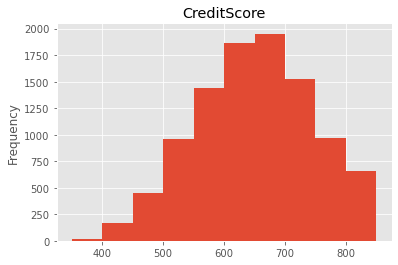

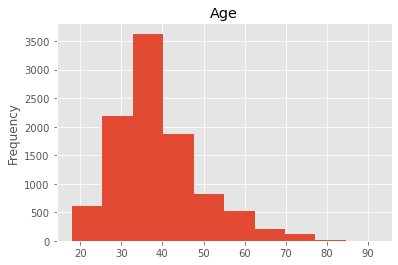

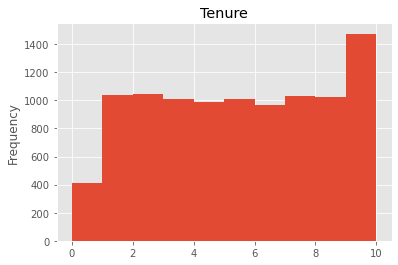

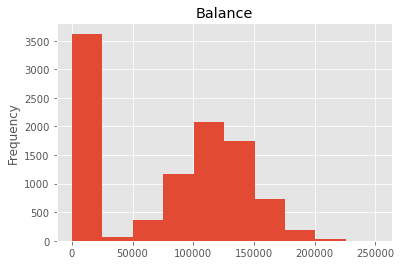

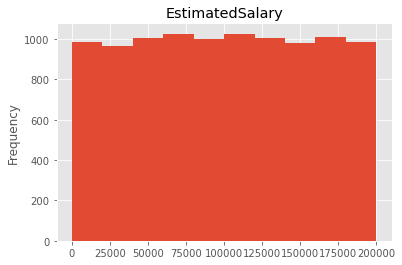

In [5]:
for col in num_idx:
    df.iloc[:, col].plot.hist(title=df.iloc[:, col].name);
    plt.show()

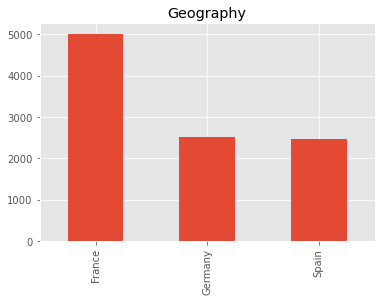

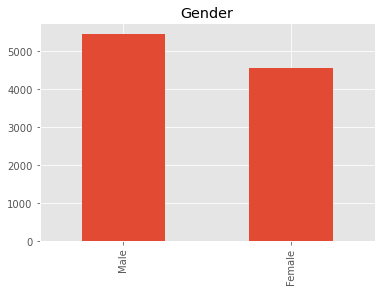

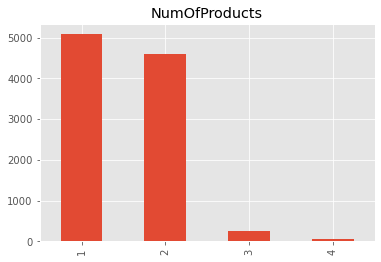

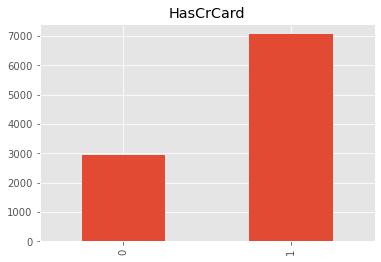

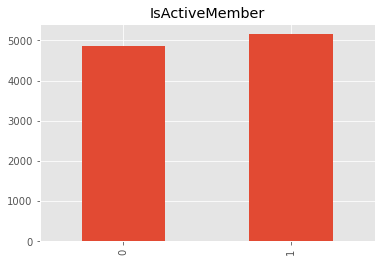

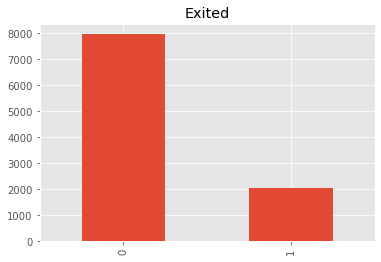

In [6]:
cat_idx = [1, 2, 6, 7, 8, 10]
for col in cat_idx:
    df.iloc[:, col].value_counts().plot.bar(title=df.iloc[:, col].name)
    plt.show()

### Analysis

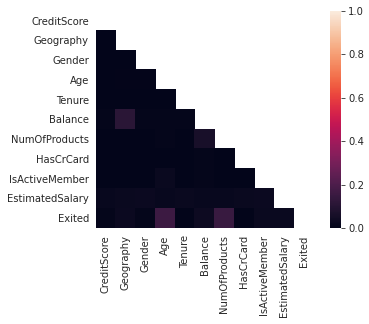

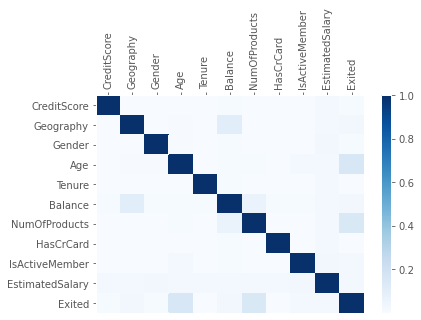

In [7]:
def discretize(x):
    if x < 2:
        return str(1)
    return str(int(math.log(x, 2) ** 2))

def cramers_V(var1,var2) :
    crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) # Cross table building
    stat = chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
    obs = np.sum(crosstab) # Number of observations
    mini = min(crosstab.shape)-1 # Take the minimum value between the columns and the rows of the cross table
    return (stat/(obs*mini))

df_disc = df.copy()

disc_values = {}
for col in num_idx:
    results = []
    for value in df_disc.iloc[:, col]:
        results.append(discretize(value))
    disc_values[col] = results

disc_values = pd.DataFrame(disc_values).values

df_disc.iloc[:, num_idx] = disc_values

n_col = df_disc.shape[1]

cramer_v_matrix = [[] for _ in range(n_col)]

for i in range(n_col):
    for j in range(n_col):
        cramer_v_matrix[i].append(cramers_V(df_disc.iloc[:, i], df_disc.iloc[:, j]))

cramer_v_matrix = pd.DataFrame(cramer_v_matrix, index=df_disc.columns, columns=df_disc.columns)

mask = np.zeros_like(cramer_v_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style('white'):
    ax = sns.heatmap(cramer_v_matrix, mask=mask, vmin=0., vmax=1., square=True)

plt.show()

fig, ax = plt.subplots()
heatmap = ax.pcolor(cramer_v_matrix, cmap=plt.cm.Blues)
cb = ax.figure.colorbar(heatmap, ax=ax)

ax.set_xticks(np.arange(cramer_v_matrix.shape[1]) + 0.5, minor=False)
ax.set_yticks(np.arange(cramer_v_matrix.shape[0]) + 0.5, minor=False)

ax.set_xlim(0, int(cramer_v_matrix.shape[1]))
ax.set_ylim(0, int(cramer_v_matrix.shape[0]))

ax.invert_yaxis()
ax.xaxis.tick_top()

ax.set_xticklabels(cramer_v_matrix.columns)
ax.set_yticklabels(cramer_v_matrix.columns)

plt.xticks(rotation=90)
plt.show()

In [8]:
df.head(10)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
5,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
6,822,France,Male,50,7,0.00,2,1,1,10062.80,0
7,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1
8,501,France,Male,44,4,142051.07,2,0,1,74940.50,0
9,684,France,Male,27,2,134603.88,1,1,1,71725.73,0
